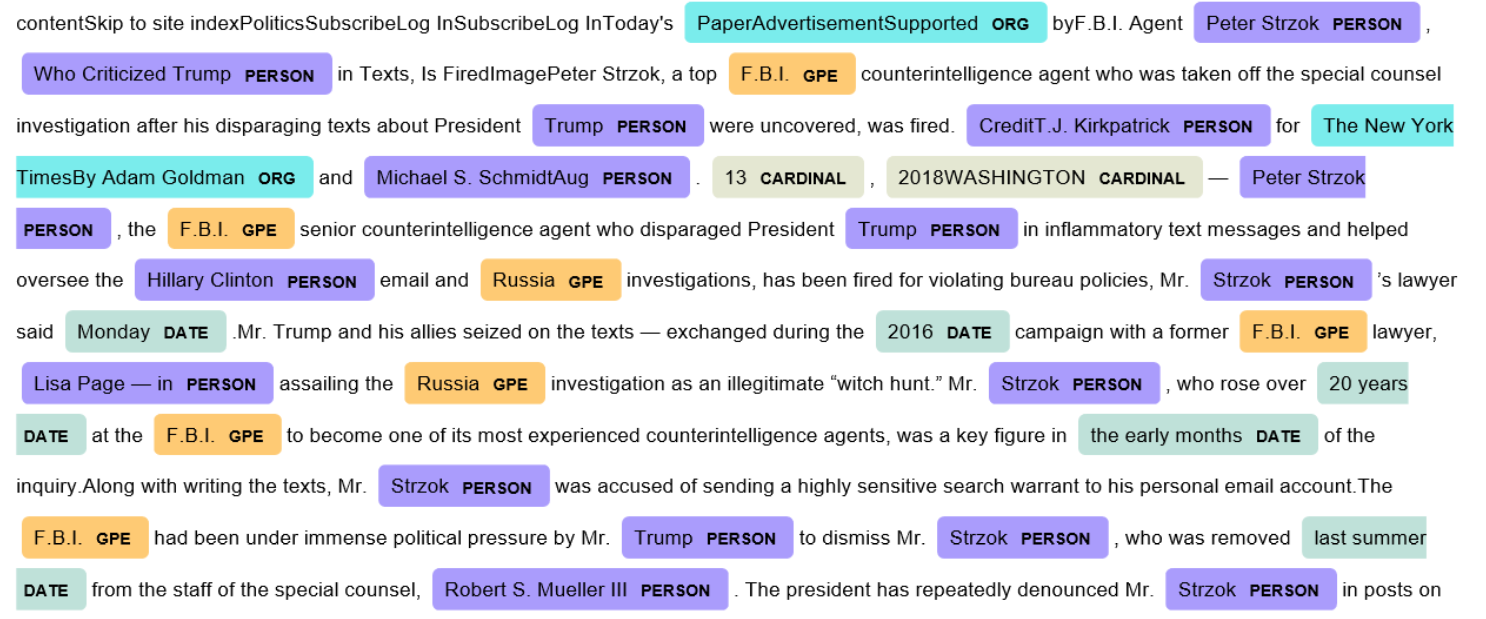

# Named Entity Recognition(NER)

Named Entity means anything that is a real-world object such as a person, a place, any organisation, any product which has a name.In Machine Learning Named Entity Recognition (NER) is a task of Natural Language Processing to identify the named entities in a certain piece of text.

Have you ever used software known as Grammarly? It identifies all the incorrect spellings and punctuations in the text and corrects it. But it does not do anything with the named entities, as it is also using the same technique.

In [1]:
import pandas as pd

data = pd.read_csv("ner_dataset.csv", encoding="unicode_escape")
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


# Data Preparation for Neural Networks

I will train a Neural Network for the task of Named Entity Recognition (NER). So we need to do some modifications in the data to prepare it in such a manner so that it can easily fit into a neutral network. I will start this step by extracting the mappings that are required to train the neural network

In [2]:
from itertools import chain

def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        vocab = list(set(data['Word'].to_list()))
    else:
        vocab = list(set(data['Tag'].to_list()))
    
    idx2tok = {idx:tok for idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok

token2idx, idx2token = get_dict_map(data, 'token')
tag2idx, idx2tag = get_dict_map(data, 'tag')

 I will transform the columns in the data to extract the sequential data for our neural network.

In [3]:
data['Word_idx'] = data['Word'].map(token2idx)
data['Tag_idx'] = data['Tag'].map(tag2idx)
data_fillna = data.fillna(method='ffill', axis=0)
# Groupby and collect columns
data_group = data_fillna.groupby(
['Sentence #'],as_index=False
)['Word', 'POS', 'Tag', 'Word_idx', 'Tag_idx'].agg(lambda x: list(x))

<ipython-input-3-f8b936d5d036>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data_group = data_fillna.groupby(


In [4]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def get_pad_train_test_val(data_group, data):

    #get max token and tag length
    n_token = len(list(set(data['Word'].to_list())))
    n_tag = len(list(set(data['Tag'].to_list())))

    #Pad tokens (X var)    
    tokens = data_group['Word_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)

    #Pad Tags (y var) and convert it into one hot encoding
    tags = data_group['Tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]
    
    #Split train, test and validation set
    tokens_, test_tokens, tags_, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)
    train_tokens, val_tokens, train_tags, val_tags = train_test_split(tokens_,tags_,test_size = 0.25,train_size =0.75, random_state=2020)

    print(
        'train_tokens length:', len(train_tokens),
        '\ntrain_tokens length:', len(train_tokens),
        '\ntest_tokens length:', len(test_tokens),
        '\ntest_tags:', len(test_tags),
        '\nval_tokens:', len(val_tokens),
        '\nval_tags:', len(val_tags),
    )
    
    return train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags

train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags = get_pad_train_test_val(data_group, data)

train_tokens length: 32372 
train_tokens length: 32372 
test_tokens length: 4796 
test_tags: 4796 
val_tokens: 10791 
val_tags: 10791


# Training Neural Network for Named Entity Recognition(NER)

I will proceed with training the neural network architecture of our model

In [5]:
import numpy as np
import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

The layer below will take the dimensions from the LSTM layer and will give the maximum length and maximum tags as an output

In [6]:
input_dim = len(list(set(data['Word'].to_list())))+1
output_dim = 64
input_length = max([len(s) for s in data_group['Word_idx'].tolist()])
n_tags = len(tag2idx)

I will create a helper function which will help us in giving the summary of every layer of the neural network model for Named Entity Recognition (NER)

In [7]:
def get_bilstm_lstm_model():
    model = Sequential()
    
    # Add Embedding layer
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length = input_length))
    
    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))
    
    # Add LSTM
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
    
    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(n_tags, activation="relu")))
    
    # Optmiser
    #adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)
    
    # Compile Model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

    

 I will create a helper function to train the Named Entity Recognition model

In [8]:
def train_model(X, y, model):
    loss = list()
    for i in range(25):
        # fit model for one epoch on this sequence
        hist = model.fit(X, y, batch_size=1000, verbose=1, epochs=1, validation_split=0.2)
        loss.append(hist.history['loss'][0])
    return loss
    

In [9]:
# Driver Code

results = pd.DataFrame()
model_bilstm_lstm = get_bilstm_lstm_model()
plot_model(model_bilstm_lstm)
results['with_add_lstm'] = train_model(train_tokens, np.array(train_tags), model_bilstm_lstm)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 104, 64)           2251072   
_________________________________________________________________
bidirectional (Bidirectional (None, 104, 128)          66048     
_________________________________________________________________
lstm_1 (LSTM)                (None, 104, 64)           49408     
_________________________________________________________________
time_distributed (TimeDistri (None, 104, 17)           1105      
Total params: 2,367,633
Trainable params: 2,367,633
Non-trainable params: 0
_________________________________________________________________
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
26/26 [==============================] - 481s 19s/step - loss: 0.0812 - accuracy: 0.9715 - val_l

## Testing The Named Entity Recognition(NER) Model

In [17]:
!pip install -U spacy
!spacy download en_core_web_sm

2021-02-07 19:37:38.671133: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll



[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [21]:
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')
text = nlp('I am a Data Analyst Intern at Data Glacier, recent BSc IT Graduate at CCT College Dublin with four years of academic knowledge in Software Development, Cloud Computing and Data Science. Also, I am a Junior Data Reporting Analyst at Honda Brazil where I worked over 2,5 years before I came to Ireland to improve my Business English and acquire a level 8 Bachelor Degree in the English language.I am actively seeking employment in the Data Analytics sector as a Data Analyst/BI Analyst. I can continue to develop new skills whilst building on my existing experience and recent training.')
displacy.render(text, style = 'ent', jupyter=True)

So we can see a very good result from our model. I hope you liked this article on Named Entity Recognition (NER) with Machine Learning.